In [2]:
import os
model_dir = "/export/linnunrata/jls/triple_models/"
os.listdir(model_dir)

['model_0000_T5750_g4.48_m-1.67_a0.07_c1.20_n0.09_broad.dat',
 'model_0000_T5750_g4.48_m-1.67_a0.07_c1.20_n0.09.dat',
 'model_0000_T5750_g4.48_m-1.67_a0.07_c1.20_n0.09.mod',
 'model_0001_T5686_g4.38_m-1.61_a0.13_c-0.20_n1.11_broad.dat',
 'model_0001_T5686_g4.38_m-1.61_a0.13_c-0.20_n1.11.dat',
 'model_0001_T5686_g4.38_m-1.61_a0.13_c-0.20_n1.11.mod',
 'model_0002_T5765_g4.21_m-1.68_a0.16_c2.90_n0.57_broad.dat',
 'model_0002_T5765_g4.21_m-1.68_a0.16_c2.90_n0.57.dat',
 'model_0002_T5765_g4.21_m-1.68_a0.16_c2.90_n0.57.mod',
 'model_0003_T5852_g4.07_m-1.63_a0.29_c1.31_n-0.38_broad.dat',
 'model_0003_T5852_g4.07_m-1.63_a0.29_c1.31_n-0.38.dat',
 'model_0003_T5852_g4.07_m-1.63_a0.29_c1.31_n-0.38.mod',
 'model_0004_T5677_g4.34_m-1.79_a0.21_c1.65_n0.63_broad.dat',
 'model_0004_T5677_g4.34_m-1.79_a0.21_c1.65_n0.63.dat',
 'model_0004_T5677_g4.34_m-1.79_a0.21_c1.65_n0.63.mod',
 'model_0005_T5677_g4.28_m-1.58_a0.10_c0.33_n1.40_broad.dat',
 'model_0005_T5677_g4.28_m-1.58_a0.10_c0.33_n1.40.dat',
 'mode

takes dereddened broadband mags - converts to fluxes - plots - overlays smoothed model spectra - adds combined spectrum too 

In [7]:
import pandas as pd
from astropy.convolution import convolve, Gaussian1DKernel

#reading the first model file and smoothing it 
#sep=r'\s+' = values separated by one or more whitespace characters 
#ignoring the first two rows
#assigning column names - wavelength, model flux, model continuum, normalized flux 
model = pd.read_csv('/export/linnunrata/jls/triple_models/model_0002_T5765_g4.21_m-1.68_a0.16_c2.90_n0.57.dat', sep=r'\s+', skiprows=2,
                    names=['WAV', 'FLUX', 'CONT', 'FLUX/CONT'])
#smoothing the FLUX column using a Gaussian kernel - mimic lower resolution
#sigma = 500 - broad smoothing kernel 
#convolve - reduces small scale noise - easier to compare with photometry
sm_model = convolve(model['FLUX'], Gaussian1DKernel(500.))
#reading the second model file and smoothing it in the same way 
model2 = pd.read_csv('/export/linnunrata/jls/triple_models/model_0007_T5777_g4.33_m-1.68_a0.09_c1.00_n0.75.dat', sep=r'\s+', skiprows=2,
                     names=['WAV', 'FLUX', 'CONT', 'FLUX/CONT'])
sm_model2 = convolve(model2['FLUX'], Gaussian1DKernel(500.))

In [8]:
import numpy as np
import matplotlib.pyplot as plt

#central wavelengths for different photometric bands in nm 
wavelengths = {
    'NUV': 230.3, 'u': 360.8, 'g': 467.2, 'r': 614.1, 'i': 745.8, 'Z': 878.9,
    'Y': 1019.6, 'J': 1248.1, 'H': 1649.9, 'Ks': 2157.8, 'W1': 3352.6, 'W2': 4602.8
}

#assumed color excess due to interstellar reddening - 0.07mag 
redd = 0.07
#extinction coefficients 
#Av / E(B-V) for each band - how much the flux is reduced by interstellar dust 
#these values are derived from the Cardelli, Clayton & Mathis (1989) extinction law (?) 
#coefficients are in magnitudes per unit of E(B-V) 
#used to deredden photometric magnitudes - can be compared with unreddened model spectra 
coeffs = {
    'NUV': 5.47, 'u': 4.58713298106561, 'g': 3.65113298106561, 'r': 2.63313298106561,
    'i': 2.04613298106561, 'z': 1.61113298106561, 'Y': 1.40613298106561,
    'J': 0.7927, 'H': 0.469, 'Ks': 0.3026
}

#extinction corrected magnitudes for each band
#using the formula: m_corrected = m_observed - reddening * coeffs[band]
#the NUV band is treated differently - it has a fixed offset of 2.5 magnitudes 
#the factor of 2.5 accounts for the logarithmic nature of magnitudes
#the factor of 1.21e8 converts the flux to Jy, and the wavelength is converted from nm to Å
#the final result is the extinction corrected magnitude for each band
#first element in the array is for star1, second for star2 
t = {
    'NUV': np.array([21.32, 21.32]) + 2.5*np.log10(2.) - redd*coeffs['NUV'],
    'u': np.array([20.131, 19.751]) - redd*coeffs['u'],
    'g': np.array([18.881, 18.728]) - redd*coeffs['g'],
    'r': np.array([18.279, 18.316]) - redd*coeffs['r'],
    'i': np.array([18.046, 18.093]) - redd*coeffs['i'],
    'Z': np.array([17.987, 18.017]) - redd*coeffs['z'],
    'Y': np.array([17.977, 18.017]) - redd*coeffs['Y'],
    'J': np.array([18.018, 18.070]) - redd*coeffs['J'],
    'H': np.array([18.096, 18.126]) - redd*coeffs['H'],
    'Ks': np.array([18.541, 18.559]) - redd*coeffs['Ks'],
    'W1': np.array([19.31, 19.44]),
    'W2': np.array([20.20, 19.87])
}

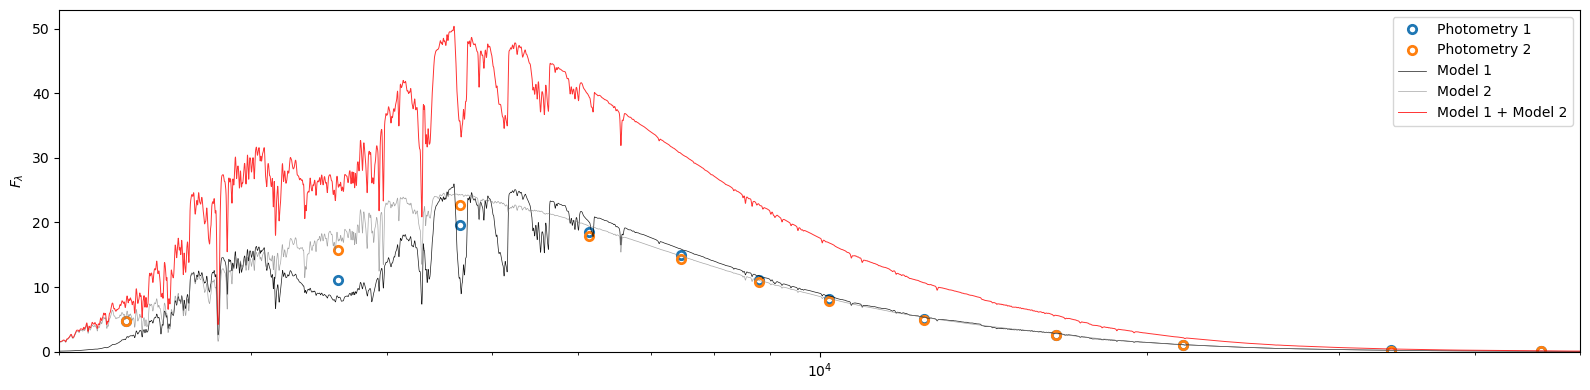

In [9]:
#starting the plot
plt.figure(figsize=(16, 4))
plt.ylabel(r'$F_\lambda$')

#converting photometric mags to fluxes 
#x axis - wavelengths in angstroms - wavelengths[b]*10 
#wavelengths are in nm, so multiplying by 10 to convert 
phot_x = [wavelengths[b]*10. for b in t.keys()]
#converting magnitudes to fluxes - physical flux density 
#10.**(-0.4*mag) - mag to flux relation - flux per unit frequency 
#*1.21e8 - scaling constant 
#(wavelengths[b]/1000.)**2 - converting per unit f to per unit wavelength 
#(wavelengths[b]/1000.)**2 - converting from nm to micrometers also 
phot_y = [10.**(-0.4*np.array(t[b])) * 1.21e8 / (wavelengths[b]/1000.)**2 for b in t.keys()]

#plotting the photometric points
#using 'o' markers with no fill color and a line width of 2 
#star 1
plt.plot(phot_x, [y[0] for y in phot_y], 'o', mfc='None', mew=2, color='C0', label='Photometry 1')
#star 2
plt.plot(phot_x, [y[1] for y in phot_y], 'o', mfc='None', mew=2, color='C1', label='Photometry 2')


#smoothed model spectra
#model['WAV'] is in angstroms, so no conversion needed 
#smoothed flux is divided by 1.16e5 to scale it to match the photometric fluxes 
#first model is in black, second in gray 
plt.plot(model['WAV'], sm_model / 1.16e5, color='k', lw=0.5, alpha=0.9, label='Model 1')
plt.plot(model2['WAV'], sm_model2 / 1.16e5, color='gray', lw=0.5, alpha=0.7, label='Model 2')

#combined model spectrum 
#adds two smoothed models together and divides by 1.16e5 to scale it 
#over the overlapping wavelengths of the two models 
#plotting in red with a line width of 0.7 and alpha of 0.8 
plt.plot(model2['WAV'], (sm_model[:len(sm_model2)] + sm_model2) / 1.16e5,
       color='r', lw=0.7, alpha=0.8, label='Model 1 + Model 2')

#axes scaling and limits
#setting x-axis to logarithmic scale for better visibility of the data 
plt.xscale('log')
#uv to mid ir range - 2000 to 50000 angstroms 
plt.xlim(2000, 50000)
#y starting from 0 to avoid negative flux values 
plt.ylim(0, None)
plt.legend()
#avoid overlapping labels and titles 
plt.tight_layout()
plt.show()


In [13]:
plate = 3314   # from SkyServer page
mjd = 54970   # from SkyServer page
fiberID = 407  # from SkyServer page

spec_list = SDSS.get_spectra(
    plate=plate, mjd=mjd, fiberID=fiberID, data_release=18
)

In [12]:
from astropy.convolution import convolve, Gaussian1DKernel
from astroquery.sdss import SDSS
from desi_retriever.dr1 import get_specs

#loading desi spectra for the gaia source
#gaia_nearby = 3651208976013623168 - gaia dr3 source id for target 
gaia_nearby = 3651208976013623168
#retriving DESI spectra for the given Gaia source id - includes ivar and fibermap
#ivar = inverse variance, fibermap = fibre metadata 
specN = get_specs(gaia_edr3_source_id=gaia_nearby, ivar=True, fibermap=True)

#obtaining sdss data for the given plate, mjd and fiberID 
plate = 3314   #from SkyServer page
mjd = 54970   #from SkyServer page
fiberID = 407  #from SkyServer page

https://data.desi.lbl.gov/public/dr1//spectro/redux/iron/healpix/main/bright/259/25943/coadd-main-bright-25943.fits


In [14]:
#downloading the spectrum fits file for observation from sdss dr18 
spec_list = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiberID, data_release=18)
#opening first spectrum's extension for flux/wavelength data 
hdul = spec_list[0][1]
#loglam = log10 of wavelength in angstroms from sdss data
#converting loglam to wavelength in angstroms
sdss_wave = 10**hdul.data['loglam']
#flux data from sdss is in units of 10^-17 erg/s/cm^2/Å
#multiply by 1e17 to put into erg/s/cm^2/Å units 
sdss_flux = hdul.data['flux'] * 1e17 

#matching the SDSS spectrum flux scale to the DESI spectrum
#desi/sdss spectra have different absolute flux scales
#need to match scales over a common wavelength range to compare them 
#using the b-arm of the DESI spectrum for matching
#b_wave = wavelength in angstroms from desi spectrum
#b_flux = flux in erg/s/cm^2/Å from desi spectrum
#copying the b_flux to avoid modifying original data 
b_wave = specN[0]['b_wavelength']
b_flux = specN[0]['b_flux'].copy()
#replacing any 0 flux values with NaN - avoid bias in medians
b_flux[b_flux == 0.] = np.nan
#slecting the overlapping wavelength range between DESI and SDSS - common region
#overlap_mask = boolean mask for wavelengths between 4000 and 5000 angstrom
overlap_mask = (b_wave > 4000) & (b_wave < 5000)
#np.interp() - resampling sdss flux onto desi wavelength grid within the overlap range
#scale_factor = median ratio of desi b flux to sdss flux in the overlap range
sdss_overlap_flux = np.interp(b_wave[overlap_mask], sdss_wave, sdss_flux)
scale_factor = np.nanmedian(b_flux[overlap_mask]) / np.nanmedian(sdss_overlap_flux)
#multiplying the sdss_flux by this scale factor - sdss matches desi flux scale 
sdss_flux *= scale_factor

In [15]:
#instrumental response function
#polynomial correction function for instrumental response
#wavelength dependent sensitivity
#for wavelengths > 5000 angstroms, use a polynomial fit - smooth curve
#for wavelengths <= 5000 angstroms, use a constant factor (1.02) - for blue end
Iinterp = lambda xx: 1. / ((1.0 - 0.04*(xx/6000.) + 0.07*(xx/6000.)**2)*(xx > 5000) +
                           1.02*(xx <= 5000))

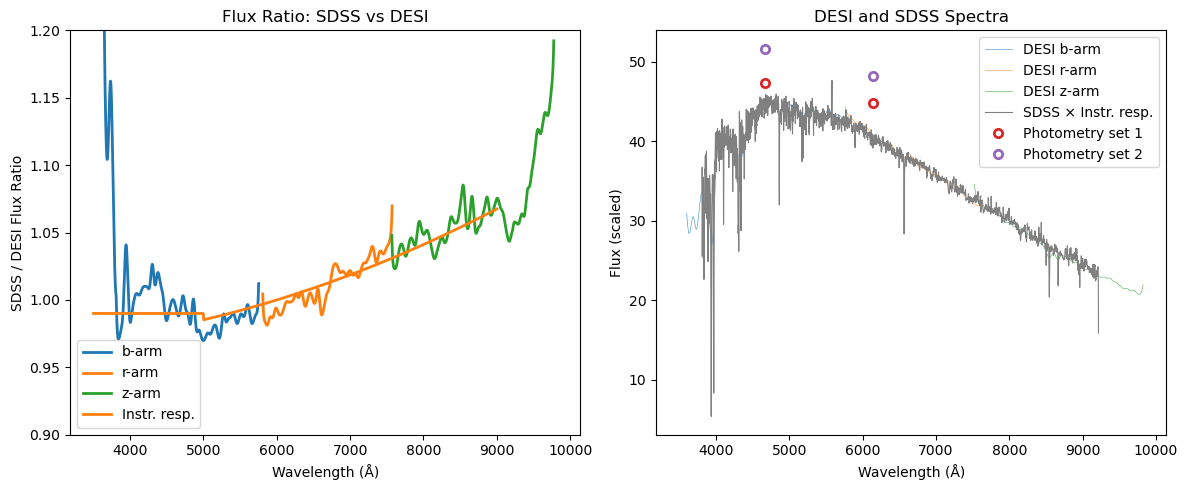

In [41]:
#figure setup for plotting - side by side 2 panel figure 
#sharing x axis scale
f, a = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

#left panel: Flux ratio - current plotting axis set to the first subplot
plt.sca(a[0])
#looping over the three wavelength ranges of DESI spectrum
#b, r, z arms
for wav_range in ['b', 'r', 'z']:
    #copy of the spectrum data for the current wavelength range 
    spp = specN[0].copy()
    #replacing any 0 flux values with NaN - avoid bias in medians
    spp[wav_range + '_flux'][spp[wav_range + '_flux'] == 0.] = np.nan
    #gaussian smoothing of the flux data - visual clarity 
    smoothing_ = 30.
    #sdss spectrum interpolated onto the desi wavelength grid 
    #avoiding edge effects by excluding the first and last 60 points
    #convolve() - smoothing the sdss flux with a Gaussian kernel 
    XX = np.interp(spp[wav_range + '_wavelength'][60:-60], sdss_wave,
                   convolve(sdss_flux, Gaussian1DKernel(smoothing_), boundary='extend'))
    #plotting the flux ratio - sdss flux / desi flux vs wavelength 
    plt.plot(spp[wav_range + '_wavelength'][60:-60],
             XX / convolve(spp[wav_range + '_flux'], Gaussian1DKernel(smoothing_))[60:-60],
             lw=2, label=f'{wav_range}-arm')

#wavelength array from 3500 to 9000 angstroms
xx = np.linspace(3500., 9000., 1000)
#plotting 1/Iinterp(xx) - 0.03 - inverse of intrumental response function minus a small offset 
plt.plot(xx, (1./Iinterp(xx)) -0.03, color='C1', lw=2, label='Instr. resp.')
#axis formatting
#setting y-axis limits to focus on the flux ratio range 
plt.ylim(0.9, 1.2)
plt.xlabel("Wavelength (Å)")
plt.ylabel("SDSS / DESI Flux Ratio")
plt.title("Flux Ratio: SDSS vs DESI")
plt.legend()

#right panel: DESI and SDSS spectra 
plt.sca(a[1])
#same smoothing applied to the desi spectrum flux
#looping over the three wavelength ranges of DESI spectrum 
for wav_range in ['b', 'r', 'z']:
    spp = specN[0].copy()
    spp[wav_range + '_flux'][spp[wav_range + '_flux'] == 0.] = np.nan
    smoothing_ = 30.
    #plotting the smoothed desi spectrum flux
    #subtracting 1 to center it around the sdss flux for comparison 
    plt.plot(spp[wav_range + '_wavelength'],
             convolve(spp[wav_range + '_flux'], Gaussian1DKernel(smoothing_), boundary='extend') - 1,
             lw=0.5, alpha=0.7, label=f'DESI {wav_range}-arm')
#smoothing the sdss flux with a Gaussian kernel 
#multiplying by the instrumental response function - matching desi shape 
plt.plot(sdss_wave,
         convolve(sdss_flux, Gaussian1DKernel(1.)) * Iinterp(sdss_wave),
         color='gray', lw=0.8, label='SDSS × Instr. resp.')

#photometry points
#magnitudes for the photometric bands
#t1 = first photometric set, t2 = second photometric set 
t1 = {'u':18.9, 'g':17.672, 'r':17.137, 'i':16.897}
t2 = {'g':22.5-2.5*np.log10(93.095),'r':22.5-2.5*np.log10(150.11256),'z':22.5-2.5*np.log10(194.79922)}
#Pwavelengths = effective wavelengths for photometric bands in nm
#converting to angstroms by multiplying by 10
Pwavelengths = {'g': 467.2, 'r': 614.1}  
plt.plot([Pwavelengths[b]*10. for b in ['g', 'r']],
         #10**(-0.4*mag) - converting magnitudes to fluxes 
         #multiplying by 1.21e14/lambda^2 to convert to erg/s/cm^2/Å 
         [10.**(-0.4*np.array(t1[b]))*1.21e14/(Pwavelengths[b])**2 for b in ['g', 'r']],
         'o', mfc='None', mew=2, label='Photometry set 1')
#same for the second photometric set 
plt.plot([Pwavelengths[b]*10. for b in ['g', 'r']],
         [10.**(-0.4*np.array(t2[b]))*1.21e14/(Pwavelengths[b])**2 for b in ['g', 'r']],
         'o', mfc='None', mew=2, label='Photometry set 2')

#axes scaling and limits
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (scaled)")
plt.title("DESI and SDSS Spectra")
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
#loading desi spectra for the two stars
gaia_id1 = 3651168951214106752
gaia_id2 = 3651168951213404672
#get_specs() - retrieves DESI spectra for the given Gaia source ids 
#inverse variance (ivar) and fibermap data included 
#spec1 and spec2 are dictionaries containing the spectra data for each arm
spec1 = get_specs(gaia_edr3_source_id=gaia_id1, ivar=True, fibermap=True)
spec2 = get_specs(gaia_edr3_source_id=gaia_id2, ivar=True, fibermap=True)

#large smoothing for clear continuum shape
smooth_model = 300.
#keep more of observed features - reduce noise on small scale   
smooth_desi   = 5.  
#left plot on blue region in optical   
zoom_region   = (3500., 6000.) 

#the synthetic spectra for two stars 
#smoothed to make them more comparable with photometry and desi spectra
sm_model  = convolve(model['FLUX'],  Gaussian1DKernel(smooth_model))
sm_model2 = convolve(model2['FLUX'], Gaussian1DKernel(smooth_model))

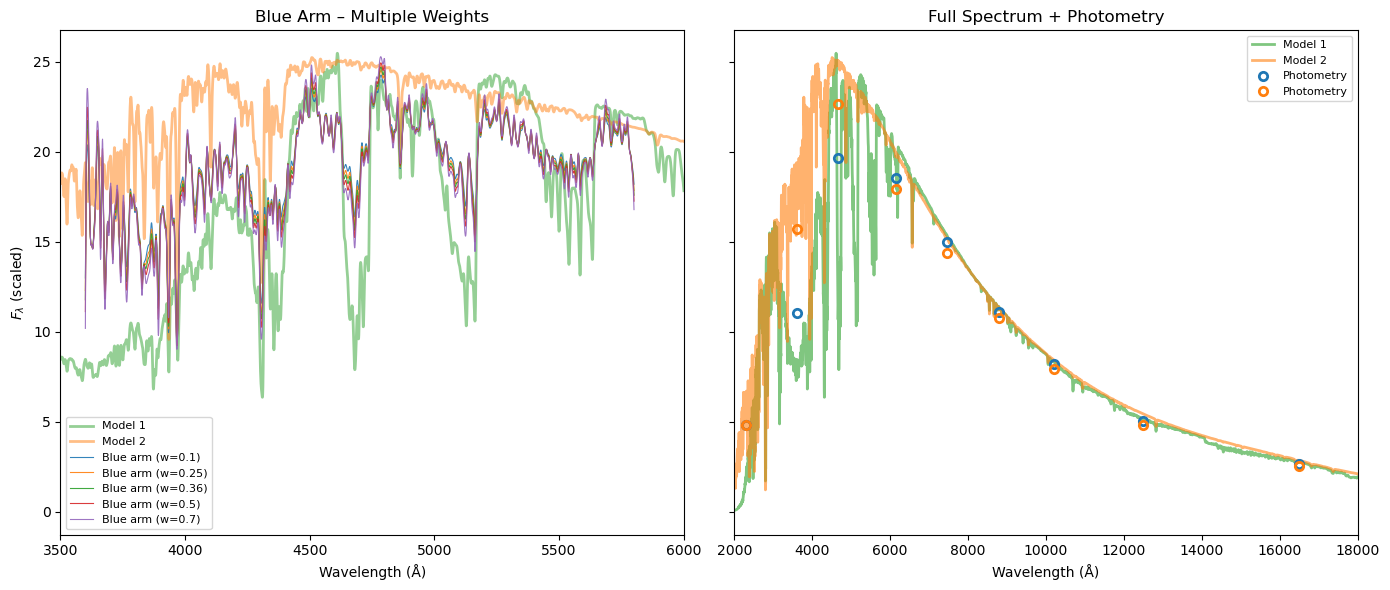

In [40]:
# two side by side panels for the plot 
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

#left panel: Blue arm only, multiple weights
ax = axes[0]
#plotting smoothed spectra models - scaled down to match desi scale
ax.plot(model['WAV'],  sm_model/1.2e5,  color='C2', lw=2, alpha=0.5, label='Model 1')
ax.plot(model2['WAV'], sm_model2/1.13e5, color='C1', lw=2, alpha=0.5, label='Model 2')
#extracting first exposure from spec1 and spec2 
#set 0 flux values to NaN to avoid bias in the plot 
spp1 = spec1[0].copy()
spp2 = spec2[0].copy()
spp1['b_flux'][spp1['b_flux'] == 0.] = np.nan
spp2['b_flux'][spp2['b_flux'] == 0.] = np.nan

#creating multiple weighted combinations of the two spectra
#weights = list of weights to apply to the two spectra
#convolve() - smoothing the combined flux with a Gaussian kernel
#boundary='extend' - extending the boundary conditions for the convolution
#plotting the weighted combinations of the two spectra 
weights = [0.1, 0.25, 0.36, 0.5, 0.7]
for w in weights:
    ax.plot(
        spp2['b_wavelength'],
        #adjusting how much each star contributes to the combined flux 
        convolve((1+w)*spp1['b_flux'] - w*spp2['b_flux'],
                 Gaussian1DKernel(smooth_desi), boundary='extend'),
        lw=0.8, alpha=0.9, label=f'Blue arm (w={w})'
    )

#zooming to the specified region 
ax.set_xlim(*zoom_region)
#labels and title for the left panel
ax.set_xlabel("Wavelength (Å)")
ax.set_ylabel(r"$F_\lambda$ (scaled)")
ax.set_title("Blue Arm – Multiple Weights")
ax.legend(fontsize=8)

#right panel: Full spectrum + Photometry 
ax = axes[1]
#plotting model spectra in the full wavelength range
ax.plot(model['WAV'],  sm_model/1.2e5,  color='C2', lw=2, alpha=0.6, label='Model 1')
ax.plot(model2['WAV'], sm_model2/1.13e5, color='C1', lw=2, alpha=0.6, label='Model 2')

#photometric points
#*10 - converting nm to angstroms 
phot_x1 = [wavelengths[b]*10. for b in wavelengths]
#converting magnitudes to fluxes - physical flux density 
phot_y1 = [10.**(-0.4*np.array(t[b]))*1.21e8/(wavelengths[b]/1000.)**2 for b in wavelengths]
ax.plot(phot_x1, phot_y1, 'o', mfc='None', mew=2, label='Photometry')

#wide wavelength range 
ax.set_xlim(2000, 18000)
ax.set_xlabel("Wavelength (Å)")
ax.set_title("Full Spectrum + Photometry")
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()